In [22]:
from reinforce import ReinforceAgent, Categorical2D
from visualisation import draw_qap, draw_assignment_graph
from qap import GraphAssignmentProblem, AssignmentGraph
from torch_geometric.utils import from_networkx
import taskgenerators
import torch
from evaluate import random_assignment
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import networkx
import nn
from pathlib import Path
from ipywidgets import interact

In [23]:
with open("testgraph.qap", "r") as f:
    qap = GraphAssignmentProblem.from_qaplib_string(f.read())

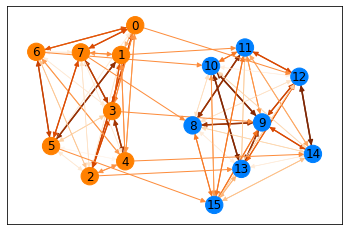

In [24]:
%matplotlib inline
draw_qap(qap, random_assignment(qap))

In [64]:
agent = ReinforceAgent()
agent.load_checkpoint("../runs/reinforce_nomessaging_histogram_fixed_deeper/")

IsADirectoryError: [Errno 21] Is a directory: '../runs/reinforce_nomessaging_histogram_fixed_deeper/'

In [65]:
agents = []
path_prefix = Path("../runs/reinforce_nomessaging_histogram_fixed_test_1/")
for fname in sorted(path_prefix.glob("checkpoint_*.pth")):
    a = ReinforceAgent()
    a.load_checkpoint(fname)
    agents.append(a)

In [17]:
agent.solve_and_learn(qap)

(12.816787523295055, array([6., 3., 0., 4., 7., 5., 2., 1.]))

In [18]:
for param in agent.networks.parameters():
    if param.grad is not None:
        print(torch.norm(param.grad))

tensor(0.0403)
tensor(0.0025)
tensor(0.0259)
tensor(0.0023)
tensor(0.0246)
tensor(0.0031)
tensor(0.0255)
tensor(0.0032)
tensor(0.0261)
tensor(0.0031)
tensor(0.0259)
tensor(0.0023)
tensor(0.0236)
tensor(0.0015)
tensor(0.0246)
tensor(0.0015)
tensor(0.0146)
tensor(0.0018)
tensor(0.0145)
tensor(0.0020)
tensor(0.0149)
tensor(0.0019)
tensor(0.0182)
tensor(0.0029)
tensor(0.0208)
tensor(0.0045)
tensor(0.0255)
tensor(0.0063)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [30]:
def plot_embedding(ax, embedding):
    with torch.no_grad():
        ax.clear()
        ax.set_ylim(-1,1)
        ax.bar(range(len(embedding)), embedding)

def show_embeddings(embeddings):
    fig,ax = plt.subplots()
    interact(lambda i: plot_embedding(ax, embeddings[i-1]), i=(1,len(embeddings)))
    fig.show()
    
def show_embeddings_series(embeddings_series):
    fig,ax = plt.subplots()
    interact(lambda i,j: plot_embedding(ax, embeddings_series[j-1][i-1]), 
             i=(1,len(embeddings_series[0])),
             j=(1,len(embeddings_series))
            )
    fig.show()

<IPython.core.display.Javascript object>


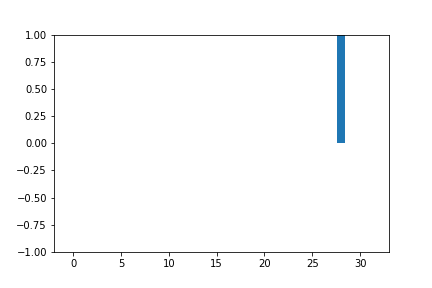

interactive(children=(IntSlider(value=28, description='i', max=56, min=1), Output()), _dom_classes=('widget-in…

In [31]:
%matplotlib notebook
# Edge embeddings
show_embeddings(data_a.edge_attr)

<IPython.core.display.Javascript object>


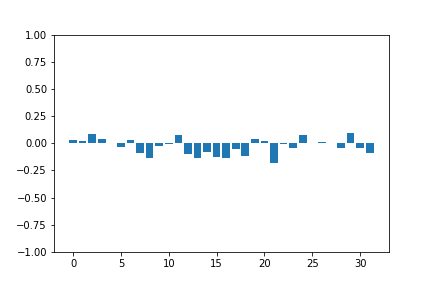

interactive(children=(IntSlider(value=4, description='i', max=8, min=1), IntSlider(value=6, description='j', m…

In [33]:
# Node embeddings
start_graph_a_by_epoch = []
start_graph_b_by_epoch = []
for agent in agents:
    start_graph_a_by_epoch.append(agent.transform_initial_graph(qap.graph_source))
    start_graph_b_by_epoch.append(agent.transform_initial_graph(qap.graph_target))
node_embedding_by_epoch = [data.x for data in start_graph_a_by_epoch]
show_embeddings_series(node_embedding_by_epoch)

In [104]:
%matplotlib notebook

def plot_matrix(ax, matrix, **kwargs):
    with torch.no_grad():
        ax.imshow(matrix, **kwargs)

def show_matrix_series(series, **kwargs):
    fig,ax = plt.subplots()
    interact(lambda i: plot_probability_matrix(ax, series[i-1], **kwargs), 
             i=(1,len(series)),
            )
    fig.show()

<IPython.core.display.Javascript object>


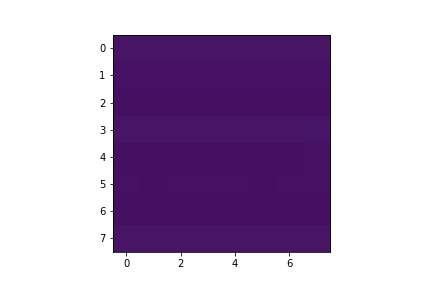

interactive(children=(IntSlider(value=6, description='i', max=11, min=1), Output()), _dom_classes=('widget-int…

In [115]:
%matplotlib notebook
# Probability matrices
probs_by_epoch = torch.stack([
    agent.compute_link_probabilities(start_graph_a_by_epoch[i].x, start_graph_b_by_epoch[i].x)
    for i, agent in enumerate(agents)
])

show_matrix_series(probs_by_epoch, vmin=torch.min(probs_by_epoch), vmax=torch.max(probs_by_epoch))

<IPython.core.display.Javascript object>


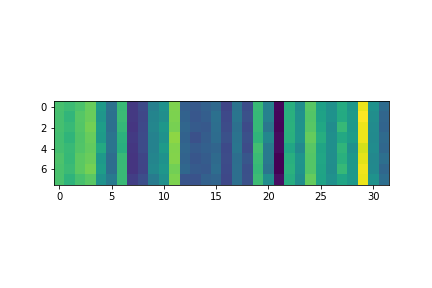

interactive(children=(IntSlider(value=6, description='i', max=11, min=1), Output()), _dom_classes=('widget-int…

In [122]:
%matplotlib notebook
show_matrix_series(node_embedding_by_epoch)

In [117]:
def print_parameter_gradients(x):
    agent.optimizer.zero_grad(set_to_none=True)
    x.backward(retain_graph=True)
    for param in agent.networks.parameters():
        if param.grad is not None:
            print(torch.norm(param.grad))

In [118]:
#print_parameter_gradients(probabilities[5,3])

In [119]:
#agent.link_freeze_net(torch.cat((embeddings_a[0], embeddings_b[1])))

In [120]:
from nn import FullyConnected, NodeTransformer, cartesian_product_matrix, concat_bidirectional, sum_incoming_edges, dense_edge_features_to_sparse
# networkx graph to connectivity matrix
connectivity_matrix = torch.tensor(networkx.linalg.adjacency_matrix(qap.graph_source).todense()).float()
# compute edge embedding vectors from weight values
edge_embeddings = nn.edge_histogram_embeddings(connectivity_matrix, agent.edge_embedding_size)
# aggregate edges and compute initial node embeddings
aggregated = sum_incoming_edges(edge_embeddings)
base_embeddings = agent.initial_node_embedding_net(aggregated)

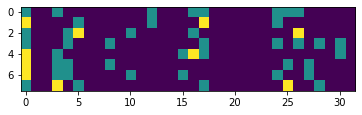

In [121]:
%matplotlib inline
plot_matrix(plt, aggregated)

In [ ]:
t1 = torch.tensor([[1,2,3],[4,5,6]])
t2 = torch.tensor([[7,8,9],[0,-1,-3]])

In [ ]:
nn.cartesian_product_matrix(t1,t2)